#### Evaluating the extent to which there is Terminal category consistency in physhchem properties that make the category amenable to TT assessment

Prepared by: Grace Patlewicz <br>
Modified: 6 November 2023 <br>
Changes: Evaluating the terminal categories developed based on Morgan FPs

This notebook computes the testing tracks, appends them to the Landscape and additionally creates 2D t-SNE plots to help explore the coverage and consistency of testing tracks across terminal categories. In the notebook , both Morgan fingerprints and TxPs were used. Pickle files are created for re-use.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os
from scipy.spatial.distance import pdist, squareform

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
processed_dir = TOP + 'data/processed/'
figures_dir = TOP + 'reports/figures/'

In [3]:
df = pd.read_excel(interim_dir+'final_universe_categorisations_wCDR_061123.xlsx' , index_col = [0])

In [4]:
df.head()

,dtxsid,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,smiles,Structure_InChI,Structure_InChIKey,Structure_Formula,Structure_MolWt,...,tsca_dist,MaxMin_tsca_picks,tsca_active_centroid,tsca_active_centroid_id,tsca_active_centroid_id2,tsca_active_analogues,tsca_active_dist,MaxMin_tsca_active_picks,CDR2019_NATIONAL_AGG_PV,CDR2020_STATUS
0,DTXSID6071908,DSSTox_High,N-Ethyl-N-((pentadecafluoroheptyl)sulphonyl)gl...,68957-63-1,Single Compound,CCN(CC(O)=O)S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)...,"InChI=1S/C11H8F15NO4S/c1-2-27(3-4(28)29)32(30,...",IOQHTIQMCISFKB-UHFFFAOYSA-N,C11H8F15NO4S,535.22,...,0.375,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DTXSID8071358,DSSTox_High,N-Methyl-perfluoro-1-heptanesulfonamide,68259-14-3,Single Compound,CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...,"InChI=1S/C8H4F15NO2S/c1-24-27(25,26)8(22,23)6(...",KDHCALLFPWZTPN-UHFFFAOYSA-N,C8H4F15NO2S,463.16,...,0.625,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DTXSID1071907,DSSTox_High,N-Ethylpentadecafluoro-1-heptanesulfonamide,68957-62-0,Single Compound,CCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,"InChI=1S/C9H6F15NO2S/c1-2-25-28(26,27)9(23,24)...",WMOMXEHEPXLIAV-UHFFFAOYSA-N,C9H6F15NO2S,477.19,...,0.600,0.0,NaN,NaN,DTXSID6027426,DTXSID1071907,0.6,0.0,NaN,NaN
3,DTXSID001026645,DSSTox_Low,"1,1,2,2,3,3,4,4,5,5,6,6,7,7,7-Pentadecafluoro-...",167398-54-1,Single Compound,OCCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,"InChI=1S/C9H6F15NO3S/c10-3(11,4(12,13)6(16,17)...",LJJUSVBJKZXMCP-UHFFFAOYSA-N,C9H6F15NO3S,493.19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DTXSID301026644,DSSTox_Low,(Perfluoroheptyl)(sulfonylamino)acetic acid,1003194-00-0,Single Compound,OC(=O)CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,"InChI=1S/C9H4F15NO4S/c10-3(11,4(12,13)6(16,17)...",LAAXCIZXZCKWFF-UHFFFAOYSA-N,C9H4F15NO4S,507.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.columns

Index(['dtxsid', 'DSSTox_QC-Level', 'Substance_Name', 'Substance_CASRN',
       'Substance_Type', 'smiles', 'Structure_InChI', 'Structure_InChIKey',
       'Structure_Formula', 'Structure_MolWt', 'Structure_SMILES_2D-QSAR',
       'Canonical_QSARr', 'TSCA_STATUS', 'chain_length', 'category',
       'MolWeight', 'LogP_pred', 'LogP_predRange', 'AD_LogP', 'AD_index_LogP',
       'Conf_index_LogP', 'MP_pred', 'MP_predRange', 'AD_MP', 'AD_index_MP',
       'Conf_index_MP', 'BP_pred', 'BP_predRange', 'AD_BP', 'AD_index_BP',
       'Conf_index_BP', 'LogVP_pred', 'VP_predRange', 'AD_VP', 'AD_index_VP',
       'Conf_index_VP', 'LogWS_pred', 'WS_predRange', 'AD_WS', 'AD_index_WS',
       'Conf_index_WS', 'LogHL_pred', 'HL_predRange', 'AD_HL', 'AD_index_HL',
       'Conf_index_HL', 'ID', 'tsca_match', 'subcategory', 'cluster',
       'cluster_centroid', 'centroid_x', 'centroid2', 'centroid_y',
       'analogues', 'Dist', 'level2_cluster_centroid', 'cluster_d',
       'lvl2_centroid', 'lvl2_centro

In [6]:
df.shape

(15414, 89)

In [7]:
df.TSCA_STATUS.value_counts(dropna = False)

unclassified    14756
inactive          337
active            321
Name: TSCA_STATUS, dtype: int64

In [8]:
df['HLC'] = df['LogHL_pred'].apply(lambda x: 10**x)
df['WS_pred_mol/L'] = df['LogWS_pred'].apply(lambda x: 10**x)
df['WS_pred_mg/L'] = df[['WS_pred_mol/L', 'MolWeight']].apply(lambda x: 1000*(x[0]*x[1]), axis = 1)

In [9]:
df.groupby('dtxsid').filter(lambda x: len(x) >1).head()

,dtxsid,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,smiles,Structure_InChI,Structure_InChIKey,Structure_Formula,Structure_MolWt,...,tsca_active_centroid_id,tsca_active_centroid_id2,tsca_active_analogues,tsca_active_dist,MaxMin_tsca_active_picks,CDR2019_NATIONAL_AGG_PV,CDR2020_STATUS,HLC,WS_pred_mol/L,WS_pred_mg/L


In [10]:
df4 = df.set_index('dtxsid')

In [11]:
df4

,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,smiles,Structure_InChI,Structure_InChIKey,Structure_Formula,Structure_MolWt,Structure_SMILES_2D-QSAR,...,tsca_active_centroid_id,tsca_active_centroid_id2,tsca_active_analogues,tsca_active_dist,MaxMin_tsca_active_picks,CDR2019_NATIONAL_AGG_PV,CDR2020_STATUS,HLC,WS_pred_mol/L,WS_pred_mg/L
dtxsid,,,,,,,,,,,,,,,,,,,,,
DTXSID6071908,DSSTox_High,N-Ethyl-N-((pentadecafluoroheptyl)sulphonyl)gl...,68957-63-1,Single Compound,CCN(CC(O)=O)S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)...,"InChI=1S/C11H8F15NO4S/c1-2-27(3-4(28)29)32(30,...",IOQHTIQMCISFKB-UHFFFAOYSA-N,C11H8F15NO4S,535.22,CCN(CC(O)=O)S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.918310e-04,1.479108e-05,7.913133
DTXSID8071358,DSSTox_High,N-Methyl-perfluoro-1-heptanesulfonamide,68259-14-3,Single Compound,CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...,"InChI=1S/C8H4F15NO2S/c1-24-27(25,26)8(22,23)6(...",KDHCALLFPWZTPN-UHFFFAOYSA-N,C8H4F15NO2S,463.16,CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.606934e-04,1.230269e-07,0.056958
DTXSID1071907,DSSTox_High,N-Ethylpentadecafluoro-1-heptanesulfonamide,68957-62-0,Single Compound,CCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,"InChI=1S/C9H6F15NO2S/c1-2-25-28(26,27)9(23,24)...",WMOMXEHEPXLIAV-UHFFFAOYSA-N,C9H6F15NO2S,477.19,CCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,...,NaN,DTXSID6027426,DTXSID1071907,0.6,0.0,NaN,NaN,6.760830e-04,4.466836e-08,0.021306
DTXSID001026645,DSSTox_Low,"1,1,2,2,3,3,4,4,5,5,6,6,7,7,7-Pentadecafluoro-...",167398-54-1,Single Compound,OCCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,"InChI=1S/C9H6F15NO3S/c10-3(11,4(12,13)6(16,17)...",LJJUSVBJKZXMCP-UHFFFAOYSA-N,C9H6F15NO3S,493.19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.165950e-11,1.445440e-05,7.125771
DTXSID301026644,DSSTox_Low,(Perfluoroheptyl)(sulfonylamino)acetic acid,1003194-00-0,Single Compound,OC(=O)CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,"InChI=1S/C9H4F15NO4S/c10-3(11,4(12,13)6(16,17)...",LAAXCIZXZCKWFF-UHFFFAOYSA-N,C9H4F15NO4S,507.17,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.011872e-11,4.897788e-05,24.829932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FDWNJOAJRRFFMD-UHFFFAOYSA-M,NaN,NaN,NaN,NaN,O=S(=O)(C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)F)[O-]...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.456542e-05,4.073803e-03,1352.325300
GJQJKNOGONJTMT-UHFFFAOYSA-M,NaN,NaN,NaN,NaN,O=C(C(F)(F)C(F)(F)C(F)F)[O-].[Ag+],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.786301e-06,1.023293e-01,20056.122958
KTMCAOSDNBNPRO-UHFFFAOYSA-M,NaN,NaN,NaN,NaN,O=S(=O)(C(F)(F)C(F)(F)C(F)(F)C(F)F)[O-].[K+],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.630781e-05,1.096478e-02,3091.626530


In [12]:
test_track = []
for i, row in df4.iterrows():
    if (row['MP_pred'] >25) & (row['WS_pred_mg/L'] < 100):
        test_track.append([i,'A'])
    elif (row['MP_pred'] >25) & (row['WS_pred_mg/L'] >=100):
        test_track.append([i,'B'])
    elif (row['BP_pred'] <25) & (row['WS_pred_mg/L'] < 100):
        test_track.append([i,'D'])
    elif (row['BP_pred'] <25) & (row['WS_pred_mg/L'] >=100) & (row['HLC'] <0.1):
        test_track.append([i,'C'])
    elif (row['BP_pred'] <25) & (row['WS_pred_mg/L'] >=100) & (row['HLC'] >=0.1):
        test_track.append([i,'D'])
    elif (row['MP_pred'] <=25) & (row['BP_pred'] >=25) & (row['WS_pred_mg/L'] >=100) & (10**row['LogVP_pred'] <=75):
        test_track.append([i,'B'])
    elif (row['MP_pred'] <=25) & (row['BP_pred'] >=25) & (row['WS_pred_mg/L'] <100):
        test_track.append([i, 'C'])
    elif (row['MP_pred'] <=25) & (row['BP_pred'] >=25) & (row['WS_pred_mg/L'] >100) & (10**row['LogVP_pred'] >75):
        test_track.append([i, 'C'])
    else:
        test_track.append([i, 'not_determined'])
                      

In [13]:
test_track = {k:v for k, v in zip(pd.DataFrame(test_track)[0], pd.DataFrame(test_track)[1])}

In [14]:
df['test_track'] = df['dtxsid'].replace(test_track)

In [15]:
df['test_track'].value_counts(dropna = False, normalize = True)

A                 0.433048
C                 0.274426
B                 0.263008
not_determined    0.020890
D                 0.008629
Name: test_track, dtype: float64

In [16]:
df['test_track'].value_counts(dropna = False)

A                 6675
C                 4230
B                 4054
not_determined     322
D                  133
Name: test_track, dtype: int64

In [75]:
df[(df['TSCA_STATUS'] == 'active') & (df['ID'].isnull())]['test_track'].value_counts(dropna = False)

C                 120
A                  78
B                  66
D                  22
not_determined      7
Name: test_track, dtype: int64

In [76]:
df[(df['TSCA_STATUS'] == 'active') & (df['ID'].isnull())]['test_track'].value_counts(normalize = True, dropna = False)

C                 0.409556
A                 0.266212
B                 0.225256
D                 0.075085
not_determined    0.023891
Name: test_track, dtype: float64

In [22]:
#chk 15092+322

In [19]:
df[df['test_track'] == 'not_determined'][[ 'MolWeight', 'LogP_pred']]

,MolWeight,LogP_pred
1442,NaN,NaN
1683,NaN,NaN
9905,NaN,NaN
14628,NaN,NaN
14629,NaN,NaN
...,...,...
15403,NaN,NaN
15404,NaN,NaN
15405,NaN,NaN
15406,NaN,NaN


In [24]:
writer = pd.ExcelWriter(interim_dir+'final_universe_wtest_track_071123.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.

df.to_excel(writer)



writer.close()

In [25]:
import sys

In [26]:
LIB = TOP+'src/models/'
if not LIB in sys.path: 
    sys.path.insert(0,LIB)

In [27]:
from model_functions import *

In [28]:
results = {}
for i, group in df.groupby('group_str'):
    try:
        a = mk_fp(group)
    except Exception as error:
        print(error)
    else:
        results[i] = a

[20:35:41] WARNING: not removing hydrogen atom without neighbors


In [44]:
len(results)

90

In [30]:
df1 = df.set_index('dtxsid')

In [31]:
phys_dict = {}
for i, group in df1.groupby('group_str'):
    phys_dict[i] = group[['LogP_pred', 'MP_pred', 'BP_pred','LogVP_pred', 
      'HLC',  'WS_pred_mg/L', 'test_track']]

In [32]:
phys_dict["('FASA based PFAA precursors', 'gte7', nan, nan)"]['test_track'].value_counts()

A    106
Name: test_track, dtype: int64

In [33]:
df1 = pd.concat([pd.DataFrame([{k:len(v) for k,v in phys_dict.items()}]).T, pd.DataFrame([{k:v['test_track'].nunique() for k,v in phys_dict.items()}]).T], axis = 1)

In [34]:
df1.columns = ['category_size', '#testing_tracks']

In [35]:
df1[df1['#testing_tracks'] >0]

,category_size,#testing_tracks
"('FASA based PFAA precursors', 'gte7', nan, nan)",106,1
"('FASA based PFAA precursors', 'lt7', nan, nan)",98,2
"('Fluorotelomer PFAA precursors', 'gte7', nan, nan)",312,3
"('Fluorotelomer PFAA precursors', 'lt7', 1.0, nan)",40,3
"('Fluorotelomer PFAA precursors', 'lt7', 2.0, 1.0)",34,3
...,...,...
"('unclassified', 'lt7', 2.0, 3.0)",66,2
"('unclassified', 'lt7', 3.0, 1.0)",15,1
"('unclassified', 'lt7', 3.0, 2.0)",34,3
"('unclassified', 'lt7', 3.0, 3.0)",61,4


In [53]:
#df_wphychem1[df_wphychem1['test_track'].isnull()]

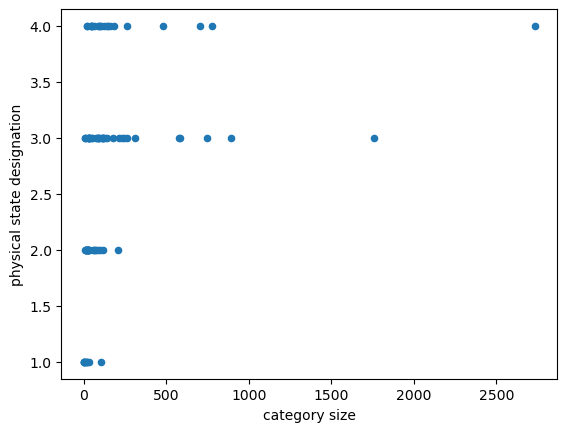

In [79]:
df1[df1['#testing_tracks'] >0].plot(kind = 'scatter', x = 'category_size', y = '#testing_tracks')
plt.ylabel('physical state designation')
plt.xlabel('category size')
plt.savefig(figures_dir+'FigureS5_061123.png', dpi = 300)

In [37]:
df1[df1['#testing_tracks']==2]

,category_size,#testing_tracks
"('FASA based PFAA precursors', 'lt7', nan, nan)",98,2
"('Fluorotelomer PFAA precursors', 'lt7', 3.0, 1.0)",24,2
"('Fluorotelomer PFAA precursors', 'lt7', 3.0, 2.0)",19,2
"('Fluorotelomer PFAA precursors', 'lt7', 3.0, 3.0)",30,2
"('Non-PFAA perfluoroalkyls', 'lt7', 2.0, 2.0)",29,2
"('Non-PFAA perfluoroalkyls', 'lt7', 2.0, 3.0)",32,2
"('PFAA precursors', 'gte7', nan, nan)",57,2
"('PFAA precursors', 'lt7', 2.0, nan)",27,2
"('PFAA precursors', 'lt7', 3.0, 2.0)",12,2
"('PFAA precursors', 'lt7', 3.0, 3.0)",15,2


In [80]:
df1[df1['#testing_tracks']==1]

,category_size,#testing_tracks
"('FASA based PFAA precursors', 'gte7', nan, nan)",106,1
"('Fluorotelomer PFAA precursors', 'lt7', 2.0, 2.0)",19,1
"('PFAA precursors', 'lt7', 1.0, 2.0)",4,1
"('PFAA precursors', 'lt7', 1.0, 3.0)",5,1
"('PFAS derivatives', 'lt7', 2.0, 2.0)",8,1
"('Unable to open ring(s)', 'lt7', nan, nan)",2,1
"('unclassified', 'gte7', 3.0, 1.0)",5,1
"('unclassified', 'lt7', 2.0, 1.0)",34,1
"('unclassified', 'lt7', 2.0, 2.0)",21,1
"('unclassified', 'lt7', 3.0, 1.0)",15,1


In [38]:
df1[df1['#testing_tracks']==4]

,category_size,#testing_tracks
"('Fluorotelomer PFAA precursors', 'lt7', 2.0, 3.0)",100,4
"('Non-PFAA perfluoroalkyls', 'lt7', 1.0, 1.0)",44,4
"('Non-PFAA perfluoroalkyls', 'lt7', 1.0, 3.0)",45,4
"('Non-PFAA perfluoroalkyls', 'lt7', 2.0, 1.0)",48,4
"('Other aliphatics', 'gte7', 1.0, nan)",707,4
"('Other aliphatics', 'lt7', 1.0, 1.0)",149,4
"('Other aliphatics', 'lt7', 1.0, 2.0)",187,4
"('Other aliphatics', 'lt7', 1.0, 4.0)",161,4
"('Other aliphatics', 'lt7', 2.0, 1.0)",106,4
"('Other aliphatics', 'lt7', 2.0, 2.0)",262,4


In [39]:
from sklearn.manifold import TSNE


In [60]:
def tsne_plots(a,b, label = None):
    summary = {}
    summary['label'] = label
    model = TSNE(learning_rate = 200, perplexity=a[label].shape[0]-1,  random_state = 42)
    tsne_features = model.fit_transform(a[label])
    tsne_features = pd.DataFrame(tsne_features, index = a[label].index, columns = ['tsne_x', 'tsne_y'])
    tsne_df = pd.concat([tsne_features, b[label]], axis = 1)
    summary['tsne'] = tsne_df
    return summary

In [61]:
#{k:v.shape for k,v in results.items()  if v.shape[0] >1}

In [62]:
tsne_lst = []
for k,v in results.items():
    try:
        a =  tsne_plots(results, phys_dict, label = k)
    except Exception as error:
        print(error, k, v.shape)
    else:
        tsne_lst.append(a)

In [63]:

for i in range(len(tsne_lst)):
    if tsne_lst[i]['label'] in df1[df1['#testing_tracks']==2].index:
        print(i, tsne_lst[i]['label'])

1 ('FASA based PFAA precursors', 'lt7', nan, nan)
7 ('Fluorotelomer PFAA precursors', 'lt7', 3.0, 1.0)
8 ('Fluorotelomer PFAA precursors', 'lt7', 3.0, 2.0)
9 ('Fluorotelomer PFAA precursors', 'lt7', 3.0, 3.0)
15 ('Non-PFAA perfluoroalkyls', 'lt7', 2.0, 2.0)
16 ('Non-PFAA perfluoroalkyls', 'lt7', 2.0, 3.0)
34 ('PFAA precursors', 'gte7', nan, nan)
38 ('PFAA precursors', 'lt7', 2.0, nan)
40 ('PFAA precursors', 'lt7', 3.0, 2.0)
41 ('PFAA precursors', 'lt7', 3.0, 3.0)
45 ('PFAAs', 'lt7', 3.0, nan)
48 ('PFAS derivatives', 'lt7', 2.0, 1.0)
51 ('PFAS derivatives', 'lt7', 3.0, nan)
53 ('PFAS derivatives', 'lt7', 4.0, 2.0)
54 ('PFAS derivatives', 'lt7', 4.0, 3.0)
56 ('Side-chain aromatics', 'gte7', 1.0, 1.0)
59 ('Side-chain aromatics', 'gte7', 2.0, nan)
61 ('Side-chain aromatics', 'lt7', 1.0, nan)
65 ('Side-chain aromatics', 'lt7', 3.0, 1.0)
75 ('unclassified', 'gte7', 1.0, nan)
79 ('unclassified', 'gte7', 3.0, 3.0)
80 ('unclassified', 'gte7', 3.0, 4.0)
85 ('unclassified', 'lt7', 2.0, 3.0)


In [64]:
import pickle

pickle.dump( tsne_lst, open(interim_dir+ "tsne_lst_081123.pkl", "wb" ) )

In [3]:
import pickle
file = open(interim_dir+ "tsne_lst_081123.pkl", 'rb')
tsne_lst = pickle.load(file)
file.close()


In [65]:
#31 ('Other aliphatics', 'lt7', 3.0, 3.0)

In [66]:
for i in range(len(tsne_lst)):
    if tsne_lst[i]['label'] in df1[df1['#testing_tracks']==4].index:
        print(i, tsne_lst[i]['label'])

6 ('Fluorotelomer PFAA precursors', 'lt7', 2.0, 3.0)
11 ('Non-PFAA perfluoroalkyls', 'lt7', 1.0, 1.0)
13 ('Non-PFAA perfluoroalkyls', 'lt7', 1.0, 3.0)
14 ('Non-PFAA perfluoroalkyls', 'lt7', 2.0, 1.0)
17 ('Other aliphatics', 'gte7', 1.0, nan)
22 ('Other aliphatics', 'lt7', 1.0, 1.0)
23 ('Other aliphatics', 'lt7', 1.0, 2.0)
25 ('Other aliphatics', 'lt7', 1.0, 4.0)
26 ('Other aliphatics', 'lt7', 2.0, 1.0)
27 ('Other aliphatics', 'lt7', 2.0, 2.0)
29 ('Other aliphatics', 'lt7', 2.0, 4.0)
31 ('Other aliphatics', 'lt7', 3.0, 2.0)
33 ('Other aliphatics', 'lt7', 3.0, 4.0)
39 ('PFAA precursors', 'lt7', 3.0, 1.0)
50 ('PFAS derivatives', 'lt7', 2.0, 3.0)
76 ('unclassified', 'gte7', 2.0, nan)
78 ('unclassified', 'gte7', 3.0, 2.0)
81 ('unclassified', 'gte7', 4.0, nan)
82 ('unclassified', 'lt7', 1.0, nan)
88 ('unclassified', 'lt7', 3.0, 3.0)
89 ('unclassified', 'lt7', 3.0, 4.0)


['C', 'D', 'B', 'A']


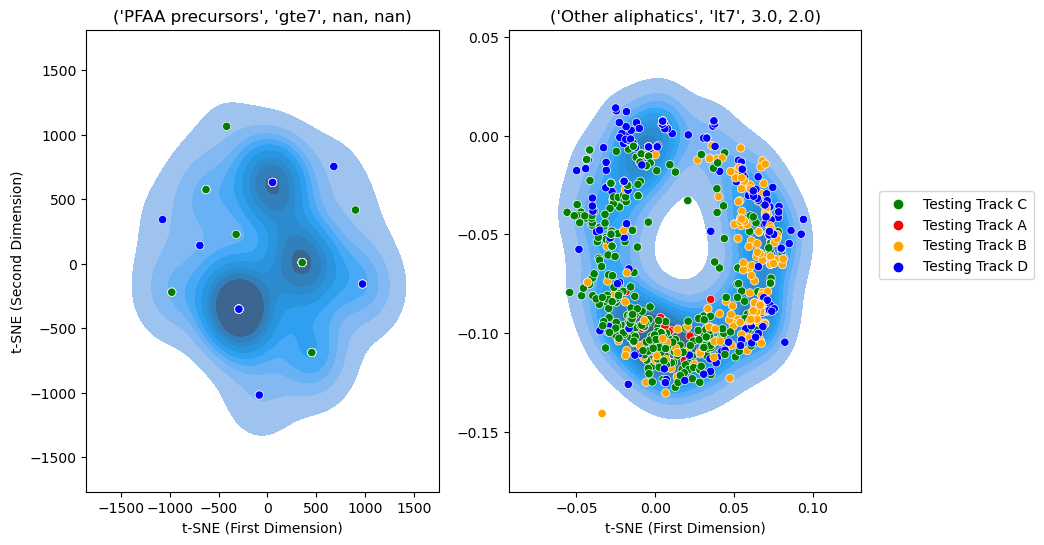

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,6))
plt.subplots_adjust(hspace = 0.8)
#colors = {1:'red', 0 : 'blue'}
color_dict = dict({'A':'blue',
                  'B':'orange',
                  'C': 'green',
                  'D': 'red'})
ax1.title.set_text(tsne_lst[34]['label'])
ax2.title.set_text(tsne_lst[31]['label'])
#grouped = tsne_df.groupby('Source')
#for key, group in grouped:
#    group.plot(ax=ax, kind='scatter', x='tsne_x', y='tsne_y', alpha = alphas[0], label=key, color=colors[key])
ax1 = sns.kdeplot(x="tsne_x", y="tsne_y", fill = True,
                     data=tsne_lst[34]['tsne'], ax = ax1)
ax1 = sns.scatterplot(x="tsne_x", y="tsne_y", hue = 'test_track',palette = color_dict,
                     data=tsne_lst[34]['tsne'], ax = ax1)

ax2 = sns.kdeplot(x="tsne_x", y="tsne_y", fill = True,
                     data=tsne_lst[31]['tsne'], ax = ax2)
ax2 = sns.scatterplot(x="tsne_x", y="tsne_y", hue = 'test_track', palette = color_dict,
                     data=tsne_lst[31]['tsne'], ax = ax2)
ax1.get_legend().remove()
ax2.set_ylabel('')
ax1.set_ylabel('t-SNE (Second Dimension)')
ax1.set_xlabel('t-SNE (First Dimension)')
ax2.set_xlabel('t-SNE (First Dimension)')
handles, labels = ax2.get_legend_handles_labels()
print(labels)
legend_order = ['Testing Track A', 'Testing Track B', 'Testing Track C', 'Testing Track D']
labels = ['Testing Track C', 'Testing Track A', 'Testing Track B', 'Testing Track D']
l = plt.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05,0.65), loc=2, borderaxespad=0.)
fig.savefig(figures_dir+'Figure9_061123.png', dpi = 300, bbox_inches = 'tight')